<a href="https://colab.research.google.com/github/eliezeravihail/BlogVer2/blob/master/Copy_of_FaceMaskClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


load Data from Google Drive

In [6]:
_URL = '/content/drive/MyDrive/archive.zip'
# zip_dir = tf.keras.utils.get_file('./archive.zip', origin =_URL, extract=True)
!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [7]:
base =  "Face Mask Dataset"
train_dir = os.path.join(base, 'Train')
validation_dir = os.path.join(base, 'Validation')
test_dir=os.path.join(base, 'Test')

train_cats_dir = os.path.join(train_dir, 'WithMask')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'WithoutMask')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'WithMask')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'WithoutMask')  # directory with our validation dog pictures

for x in os.listdir(test_dir):
  print (x)



WithoutMask
WithMask


In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val


print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 5000
total training dog images: 5000
total validation cat images: 400
total validation dog images: 400
--
Total training images: 10000
Total validation images: 800


In [9]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150


In [10]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)


In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [20]:
sample_training_images, _ = next(train_data_gen) 


In [21]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    plotImages(sample_training_images[:5]) 
    

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [18]:
EPOCHS = 5
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 433s 4s/step - loss: 0.3906 - accuracy: 0.7986 - val_loss: 0.0530 - val_accuracy: 0.9837
Epoch 2/5
100/100 [==============================] - 438s 4s/step - loss: 0.0602 - accuracy: 0.9783 - val_loss: 0.0412 - val_accuracy: 0.9862
Epoch 3/5
100/100 [==============================] - 428s 4s/step - loss: 0.0611 - accuracy: 0.9780 - val_loss: 0.0254 - val_accuracy: 0.9887
Epoch 4/5
100/100 [==============================] - 424s 4s/step - loss: 0.0255 - accuracy: 0.9900 - val_loss: 0.0231 - val_accuracy: 0.9900
Epoch 5/5
100/100 [==============================] - 424s 4s/step - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0132 - val_accuracy: 0.9962


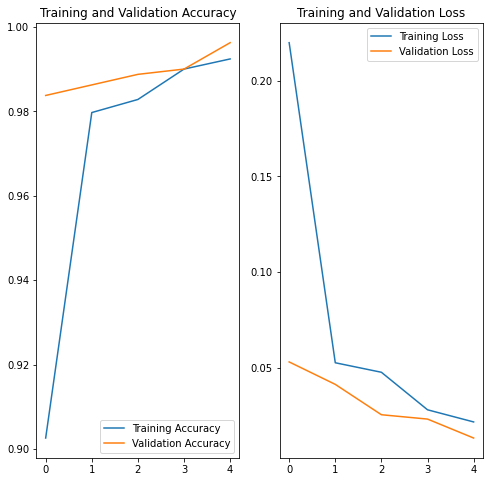

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()